- 7 카메라 스티커앱 만들기 첫걸음

<<목차>>

1) 데이터 준비
    - 패키지 준비
    - 이미지 읽어오기
    - cvtColor()

    
2) face detection
    - dlib의 'face detector'는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)으로 detect
    - HOG detector로 bounding box 추출

    
3) face landmark
    - Object keypoint estimation

    - Dlib landmark localization

4) 스티커 적용
    - 스티커를 적용할 위치 좌표
    - 사진의 형태에 따른 크기 조정
    - 다듬어주기(crop)
    - sticker area

    
5) 후처리
 
    
    
6) 루브릭

1_ 자기만의 카메라앱 기능 구현을 완수하였다.
얼굴 영역과 랜드마크를 정확하게 검출하고, 스티커 사진을 합성시키는 데 성공하였다.

2_ 스티커 이미지를 정확한 원본 위치에 반영하였다.
정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.

3_ 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.
얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.


7) 회고

1) 데이터 준비

In [516]:
#패키지 준비
    
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 

print(cv2.__version__)
print(dlib.__version__)

4.6.0
19.24.0


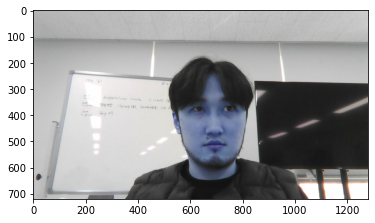

In [517]:
#이미지 읽어오기

my_image_path = '/home/june/2022-10-07.jpg' # 본인 이미지가 있는 경로를 가지고 온다
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러온다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관한다
plt.imshow(img_bgr) # 이미지를 출력하기 위해 출력할 이미지를 올려준다
plt.show() # 이미지를 출력

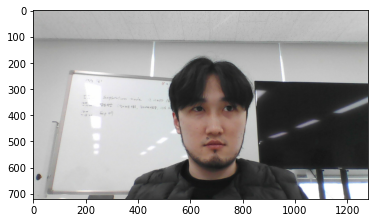

In [518]:
# cvtCorlor() 메소드로 BGR을 RGB로 바꾸기 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌
plt.show() # 이미지 실제 출력

2) face detection

In [519]:
# dlib의 'face detector'는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)으로 얼굴 detect

detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(557, 320) (825, 587)]]


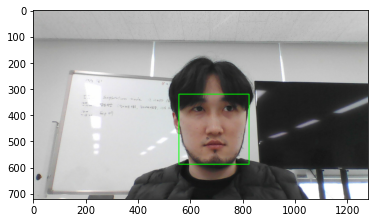

In [520]:
#HOG detector로 bounding box 추출

print(dlib_rects)   

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

3) face landmark

In [521]:
# Object keypoint estimation : 
# Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라 부르고 크게 2가지로 나뉨
#    1. top-down : bounding box를 찾고 box 내부의 keypoint를 예측
#    2. bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

model_path = '/home/june/shape_predictor_68_face_landmarks.dat'
    # 저장한 landmark 모델의 주소를 model_path 변수에 저장
landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

In [522]:
#Dlib landmark localization

list_landmarks = []
    # 랜드마크의 위치를 저장할 list 생성    

# 얼굴 영역 박스 마다 face landmark를 찾아냄
# face landmark 좌표를 저장
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list 
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

68


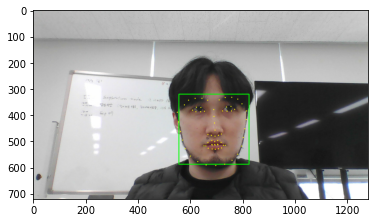

In [523]:
#랜드마크 로칼라이제이션 출력

# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    # RGB 이미지로 전환
plt.imshow(img_show_rgb)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

4) 스티커 적용

In [524]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
print(dlib_rect)
# → rectangles[[(557, 320) (825, 587)]]

print(list_landmarks)
# [[0(551, 389),  1(555, 426),  2(563, 462),  3(571, 495),  4(581, 528),  5(601, 556),  6(629, 577),  7(661, 590),  8(698, 592),  9(732, 587),
#  10(760, 572), 11(782, 549), 12(797, 518), 13(803, 485), 14(809, 452), 15(815, 417), 16(816, 384), 17(578, 361), 18(594, 343), 19(619, 336),
#   (645, 336), (667, 343), (711, 342), (734, 333), (759, 332), (782, 339), (798, 357), (690, 379), (691, 405), (693, 430), 
#   (695, 457), (668, 474), (681, 477), (695, 480), (708, 477), (719, 472), (609, 381), (624, 370), (641, 371), (655, 385), 
#   (640, 387), (622, 387), (724, 384), (739, 369), (756, 367), (770, 378), (758, 384), (741, 385), (653, 517), (668, 505), 
#   (683, 497), (694, 501), (705, 497), (718, 504), (734, 515), (720, 525), (708, 528), (696, 530), (684, 529), (669, 526), 
#   (660, 517), (683, 512), (694, 512), (705, 511), (727, 515), (706, 513), (695, 514), (684, 514)]]


for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[30]) # 코의 index는 30(695, 457) 입니다
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = landmark[30][1] + dlib_rect.height()//2  # 이미지에서 코 부위의 y값
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

[(557, 320) (825, 587)]
[[(551, 389), (555, 426), (563, 462), (571, 495), (581, 528), (601, 556), (629, 577), (661, 590), (698, 592), (732, 587), (760, 572), (782, 549), (797, 518), (803, 485), (809, 452), (815, 417), (816, 384), (578, 361), (594, 343), (619, 336), (645, 336), (667, 343), (711, 342), (734, 333), (759, 332), (782, 339), (798, 357), (690, 379), (691, 405), (693, 430), (695, 457), (668, 474), (681, 477), (695, 480), (708, 477), (719, 472), (609, 381), (624, 370), (641, 371), (655, 385), (640, 387), (622, 387), (724, 384), (739, 369), (756, 367), (770, 378), (758, 384), (741, 385), (653, 517), (668, 505), (683, 497), (694, 501), (705, 497), (718, 504), (734, 515), (720, 525), (708, 528), (696, 530), (684, 529), (669, 526), (660, 517), (683, 512), (694, 512), (705, 511), (727, 515), (706, 513), (695, 514), (684, 514)]]
(695, 457)
(x,y) : (695,591)
(w,h) : (269,269)


In [525]:
# 스티커 적용

sticker_path = '/home/june/24674.png' # 스티커 이미지의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
print (img_sticker.shape) # 사이즈를 조정한 스티커 이미지의 차원 확인

(269, 269, 3)


In [526]:
# x,y,w,h 모두 위에서 반복문 안에서 지정해준 값임
# x는 이미지에서 코 부위의 x값 = 695
# y는 이미지에서 코 부위의 y값 = 457
# w는 얼굴 영역의 가로를 차지하는 픽셀의 수 = 269
# h는 얼굴 영역의 가로를 차지하는 픽셀의 수 = 269
refined_x = x - w // 2 # 695 - (269//2) = 695-134 = 561
refined_y = y - h # 457-269 = 188
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.
# 즉, refined_x, refined_y값에서 왕관 이미지가 시작됨
print ('(x,y) : (%d,%d)'%(refined_x, refined_y)) 

(x,y) : (561,322)


In [527]:
# 스티커 이미지가 이미지 밖에서 시작하지 않도록 조정이 필요함
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# 현재 상황에서는 -y 크기만큼 스티커를 crop 하고, top 의 x좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정하면 아래와 같은 형식으로 나옵니다.
# 음수값 만큼 스티커 이미지(혹은 추후 적용할 스티커 이미지)를 자른다.
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
# 스티커 이미지를 씌우기 위해 스티커 이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] # refined_y가 양수이므로, (187, 187, 3)에서 아무것도 잘려나가지 않음.
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (561,322)


In [528]:
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# 스티커 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 스티커 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# 그렇기 때문에 0인 부분(이미지가 없는 부분)은 제외하고 적용
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(스티커 이미지에서 스티커 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(스티커 이미지)를 적용한다.
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

스티커의 투명 배경의 흰색으로 나오고 검은색의 수염부분이 자꾸 투명색으로 나와 어떻게 해결해야하는지 나름대로 고민해보고 찾아보아야 했다. 동료의 도움으로 알게된것인데,

np.where(img_sticker==0에서 0을 255로 바꿔줘야했다.

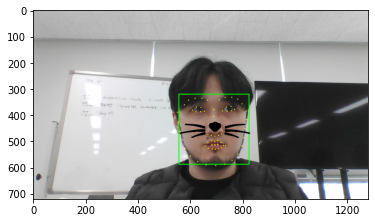

In [529]:
# 스티커 이미지를 적용한 이미지를 보여준다.
# 얼굴 영역(7-3)과 랜드마크(7-4)를 미리 적용해놓은 img_show에 스티커 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

5) 후처리

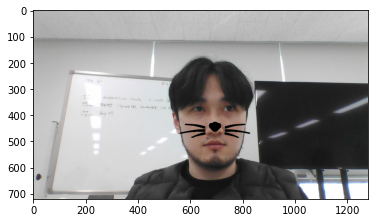

In [538]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지이다. 
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 스티커 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

6) 루브릭

1_ 자기만의 카메라앱 기능 구현을 완수하였다.
얼굴 영역과 랜드마크를 정확하게 검출하고, 스티커 사진을 합성시키는 데 성공하였다.

2_ 스티커 이미지를 정확한 원본 위치에 반영하였다.
정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.

3_ 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.
얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.

7) 회고

- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.낌
- **자기 다짐**